# PARTE II

## Importar bibliotecas e pacotes relevantes

In [0]:
%matplotlib inline

import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, shapiro
from statsmodels.graphics.gofplots import qqplot
from pandas.plotting import scatter_matrix
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

## Leitura da base de dados

In [4]:
path = '/content/drive/My Drive/PUC/Pós/TEP/Exercício 1/'
filename = 'cereal.csv'

df = pd.read_csv(path + filename, index_col=0)
df.head()

,mfr,type,calories,protein,fat,sodium,fiber,carbo,sugars,potass,vitamins,shelf,weight,cups,rating
name,,,,,,,,,,,,,,,
100% Bran,N,C,70,4,1,130,10.0,5.0,6,280,25,3,1.0,0.33,68.402973
100% Natural Bran,Q,C,120,3,5,15,2.0,8.0,8,135,0,3,1.0,1.00,33.983679
All-Bran,K,C,70,4,1,260,9.0,7.0,5,320,25,3,1.0,0.33,59.425505
All-Bran with Extra Fiber,K,C,50,4,0,140,14.0,8.0,0,330,25,3,1.0,0.50,93.704912
Almond Delight,R,C,110,2,2,200,1.0,14.0,8,-1,25,3,1.0,0.75,34.384843


## I – Classifique cada variável envolvida no problema.


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 77 entries, 100% Bran to Wheaties Honey Gold
Data columns (total 15 columns):
mfr         77 non-null object
type        77 non-null object
calories    77 non-null int64
protein     77 non-null int64
fat         77 non-null int64
sodium      77 non-null int64
fiber       77 non-null float64
carbo       77 non-null float64
sugars      77 non-null int64
potass      77 non-null int64
vitamins    77 non-null int64
shelf       77 non-null int64
weight      77 non-null float64
cups        77 non-null float64
rating      77 non-null float64
dtypes: float64(5), int64(8), object(2)
memory usage: 9.6+ KB


In [0]:
# Uma vez que existem diferentes volumes de porções, os dados nutricionais serão divididos pelo volume
# para padronizar as comparações. X [cal|g/serving] --> X [cal|g/oz]

df2 = df.loc[:, ['mfr', 'type', 'shelf', 'rating', 'vitamins']]

df2['calories_oz'] = df['calories'] / df['weight']
df2['protein_oz'] = df['protein'] / df['weight']
df2['fat_oz'] = df['fat'] / df['weight']
df2['sodium_oz'] = df['sodium'] / df['weight']
df2['fiber_oz'] = df['fiber'] / df['weight']
df2['carbo_oz'] = df['carbo'] / df['weight']
df2['sugars_oz'] = df['sugars'] / df['weight']
df2['potass_oz'] = df['potass'] / df['weight']

# Feito isso, os atributos 'weight' e 'cups' podem ser descartados

## Limpeza dos dados

In [7]:
df2.replace(to_replace=-1, value=np.nan, inplace=True)
df2.dropna(inplace=True)
df2.shape

(74, 13)

In [0]:
# Classificação das variáveis
quali = ['mfr', 'type', 'shelf', 'vitamins']
quanti = ['calories_oz', 'protein_oz', 'fat_oz', 'sodium_oz', 'fiber_oz', 
          'carbo_oz', 'sugars_oz', 'potass_oz', 'rating']

In [0]:
dfQuanti = df2.loc[:, quanti]
dfQuali = df2.loc[:, quali].astype('category')

## II – Realize uma análise descritiva individual para cada variável.

In [10]:
# Variáveis qualitativas
dfQuali.describe()

,mfr,type,shelf,vitamins
count,74,74,74,74
unique,7,2,3,3
top,K,C,3,25
freq,23,73,35,62


In [11]:
# Descrição das variáveis quantitativas
dfQuanti.describe().applymap(lambda x: f'{x:.1f}')

,calories_oz,protein_oz,fat_oz,sodium_oz,fiber_oz,carbo_oz,sugars_oz,potass_oz,rating
count,74.0,74.0,74.0,74.0,74.0,74.0,74.0,74.0,74.0
mean,104.0,2.5,1.0,155.8,2.1,14.5,6.7,93.7,42.4
std,14.1,1.1,1.0,81.9,2.3,4.2,4.1,64.0,14.0
min,50.0,1.0,0.0,0.0,0.0,5.0,0.0,20.0,18.0
25%,100.0,2.0,0.0,127.0,0.2,11.4,3.0,41.2,32.4
50%,107.2,2.1,1.0,161.7,1.8,14.0,6.0,90.0,40.3
75%,110.0,3.0,1.0,207.5,3.0,17.0,10.0,114.9,50.5
max,150.0,6.0,5.0,320.0,14.0,26.0,15.0,330.0,93.7


## III– Construa uma matriz de correlação com as variáveis quantitativas. Avalie quais correlações são significativas. Determine qual variável está mais correlacionada com a Pressão diastólica.

In [0]:
def pearson_pvalue(x, y):
  '''Função 'callable' para retornar o valor p
  de uma correlação entre x e y'''
  return pearsonr(x, y)[1]

In [13]:
# Correlações das variáveis
correlations = dfQuanti.corr(method='pearson')
p_values = dfQuanti.corr(method=pearson_pvalue)

'''# Filtro para apenas a matriz triangular inferior
mask = np.tril(np.ones(correlations.shape), k=-1).astype(np.bool)

correlations.where(mask, inplace=True)
p_values.where(mask, inplace=True)'''

 #Considerando significativa uma correlação com |R²| >= k
k = 0.5
correlations[abs(correlations) >= k].fillna('')

,calories_oz,protein_oz,fat_oz,sodium_oz,fiber_oz,carbo_oz,sugars_oz,potass_oz,rating
calories_oz,1,,,,-0.665157,,,-0.548822,-0.651377
protein_oz,,1,,,,,,0.53096,0.583131
fat_oz,,,1,,,,,,
sodium_oz,,,,1,,,,,
fiber_oz,-0.665157,,,,1,,,0.919284,0.662531
carbo_oz,,,,,,1,-0.635888,,
sugars_oz,,,,,,-0.635888,1,,-0.761805
potass_oz,-0.548822,0.53096,,,0.919284,,,1,0.531962
rating,-0.651377,0.583131,,,0.662531,,-0.761805,0.531962,1


In [14]:
dfQuanti.corr(method='pearson').style.background_gradient(cmap='RdBu_r', axis=None).set_precision(3)
#correlations.fillna(0).style.background_gradient(cmap='RdBu_r', axis=None)

,calories_oz,protein_oz,fat_oz,sodium_oz,fiber_oz,carbo_oz,sugars_oz,potass_oz,rating
calories_oz,1,-0.175,0.491,0.123,-0.665,0.213,0.38,-0.549,-0.651
protein_oz,-0.175,1,0.138,-0.0924,0.474,-0.0301,-0.461,0.531,0.583
fat_oz,0.491,0.138,1,-0.0156,-0.0161,-0.381,0.271,0.161,-0.391
sodium_oz,0.123,-0.0924,-0.0156,1,-0.139,0.148,-0.0208,-0.162,-0.352
fiber_oz,-0.665,0.474,-0.0161,-0.139,1,-0.426,-0.275,0.919,0.663
carbo_oz,0.213,-0.0301,-0.381,0.148,-0.426,1,-0.636,-0.481,0.234
sugars_oz,0.38,-0.461,0.271,-0.0208,-0.275,-0.636,1,-0.199,-0.762
potass_oz,-0.549,0.531,0.161,-0.162,0.919,-0.481,-0.199,1,0.532
rating,-0.651,0.583,-0.391,-0.352,0.663,0.234,-0.762,0.532,1


In [15]:
p_values.style.background_gradient(cmap='RdBu_r', axis=None).set_precision(3)

,calories_oz,protein_oz,fat_oz,sodium_oz,fiber_oz,carbo_oz,sugars_oz,potass_oz,rating
calories_oz,1,0.135,8.91e-06,0.297,1.02e-10,0.0681,0.000853,4.13e-07,3.29e-10
protein_oz,0.135,1,0.243,0.434,2.01e-05,0.799,3.59e-05,1.14e-06,4.99e-08
fat_oz,8.91e-06,0.243,1,0.895,0.892,0.000808,0.0193,0.172,0.000582
sodium_oz,0.297,0.434,0.895,1,0.239,0.208,0.86,0.169,0.00213
fiber_oz,1.02e-10,2.01e-05,0.892,0.239,1,0.000151,0.0176,7.09e-31,1.28e-10
carbo_oz,0.0681,0.799,0.000808,0.208,0.000151,1,1.15e-09,1.41e-05,0.0444
sugars_oz,0.000853,3.59e-05,0.0193,0.86,0.0176,1.15e-09,1,0.0898,3.23e-15
potass_oz,4.13e-07,1.14e-06,0.172,0.169,7.09e-31,1.41e-05,0.0898,1,1.07e-06
rating,3.29e-10,4.99e-08,0.000582,0.00213,1.28e-10,0.0444,3.23e-15,1.07e-06,1


In [16]:
# Variável mais correlacionada com 'PDiasto'
correlations[correlations != 1].loc['rating'].nlargest(5)

fiber_oz      0.662531
protein_oz    0.583131
potass_oz     0.531962
carbo_oz      0.234448
sodium_oz    -0.351558
Name: rating, dtype: float64

## IV – Construa um modelo de regressão com todas as variáveis qualitativas e quantitativas.

- Analise a tabela ANOVA para o modelo.
- Determine quais as variáveis são significativas.
- Interprete o parâmetro de qualidade de ajuste R².
- Faça uma análise de resíduos.


### a) Construção do modelo (I)

In [0]:
# Para incluir variáveis categóricas é necessário codificá-las no DF original
# Técnica: 'One Hot Encoding'

# DataFrame com todas as variaveis categóricas 'binarizadas'
'''drop_first é usado para remover uma das colunas de cada categoria, evitando multicolinearidade
uma vez que em cada caso, uma das variáveis pode ser calculada (prevista) pelo valor das outras'''
dfDummies = pd.get_dummies(df2, columns=quali, drop_first=True)

In [0]:
# Construção do modelo linear usando Statsmodel OLS
X = dfDummies.drop('rating', axis=1)
y = dfDummies['rating']

# Adicionar manualmente opção para aplicar regressão com coeficiente linear
x = sm.add_constant(X)

model = sm.OLS(y, x).fit()
print(model.summary())

In [0]:
def print_anova(m):
  print('TABELA ANOVA\n')
  data = [('Modelo', m.ess, m.df_model, m.mse_model, m.fvalue),
          ('Resíduo', m.ssr, m.df_resid, m.mse_resid)]
  labels = ['Variação', 'Soma de Quadrados', 'Graus de Liberdade', 'Erro médio', 'Valor F']
  df = pd.DataFrame.from_records(data, columns=labels).set_index('Variação')
  print(df.apply(lambda x: round(x, 2)).head(2))

In [0]:
# Tabela ANOVA
print_anova(model)

TABELA ANOVA

          Soma de Quadrados  Graus de Liberdade  Erro médio  Valor F
Variação                                                            
Modelo             14220.41                18.0      790.02    277.5
Resíduo              156.58                55.0        2.85      NaN


### b) Determinação das variáveis significativas

In [0]:
df_sig = pd.DataFrame(model.pvalues[1:],
                      columns=['Valor-p'])
df_sig['Significativo ?'] = df_sig['Valor-p'].apply(lambda x: 'Sim' if x < 0.05 else 'Não')
df_sig

,Valor-p,Significativo ?
calories_oz,1.679615e-07,Sim
protein_oz,7.668849e-17,Sim
fat_oz,2.731968e-01,Não
sodium_oz,1.646472e-16,Sim
fiber_oz,1.714776e-18,Sim
carbo_oz,2.927579e-09,Sim
sugars_oz,6.637226e-02,Não
potass_oz,4.632397e-06,Sim
mfr_G,1.363190e-09,Sim
mfr_K,4.716165e-09,Sim


Resultados relevantes do modelo:

- Valor p << 0.05, indica resultado significativo

- Apenas 4 variáveis (além do coeficiente linear) apresentaram valor-p < 0.05, indicando boa significância:
> Os coeficientes podem ser úteis para prever como sua variação afeta a variável resposta
  - Idade
  - IMC
  - frqCardiaca
  - Sexo_Masculino

- Como previsto pela matriz de correlações, as fortes relações entre variáveis explicativas geraram problemas associados a multicolinearidade
> IMC, Ccintura e Cquadril

- Apenas o sexo, dentre as variáveis categóricas, apresentou resultados significativos para ser considerada relevante

### c) Interpretação dos parâmetros do ajuste R²

In [0]:
print(model.rsquared, model.rsquared_adj)

0.9891090193800683 0.9855446984499089


- R² = 0.173 e R²(ajustado) = 0.146
> Indício que o modelo não se ajusta bem à variabilidade em torno da média 

> A precisão das previsões do modelo não é boa (apesar de aceitável para alguns tipos de estudo), de forma que o IC de um dado previsto terá alta variabilidade


### d) Análise de resíduos

A ideia principal é avaliar a natureza aleatória, variância e distribuição dos resíduos.

O ajuste linear deve levar em consideração as hipóteses de:
- Linearidade
- Independência dos resíduos
- Homocedasticidade (variância constante)
- Normalidade dos resíduos
- Ausência de multicolinearidade (regressão múltipla)

#### d.1) Plot Resíduos x Variáveis preditivas

Objetivo: Checar independência dos resíduos
> A suposição é válida caso os resíduos estejam distribuídos aleatoriamente em torno do eixo x=0.

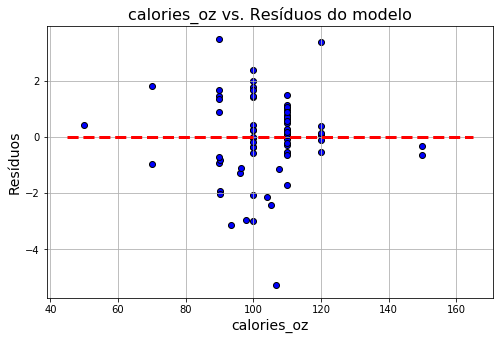

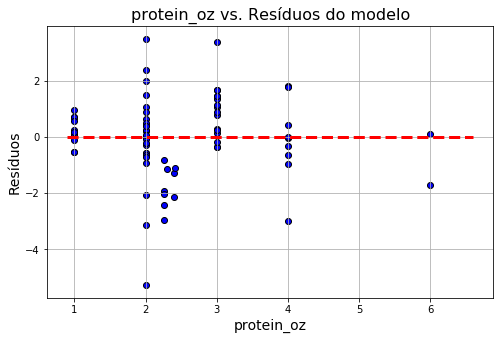

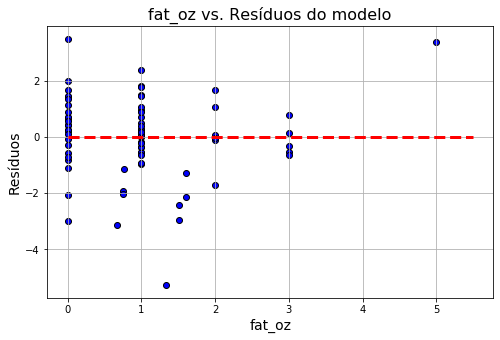

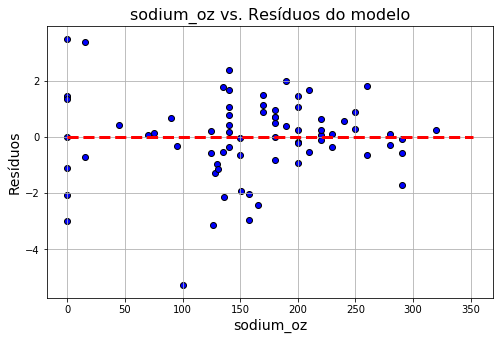

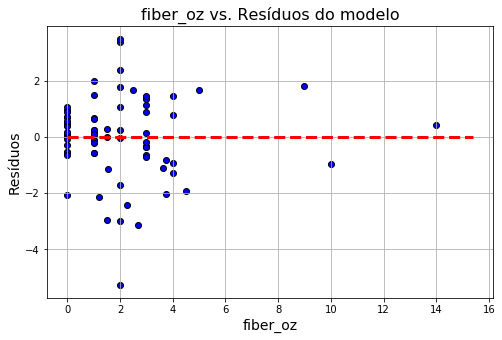

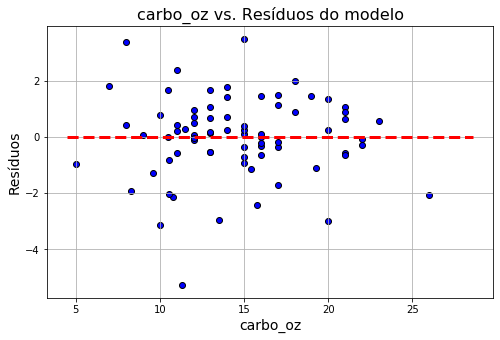

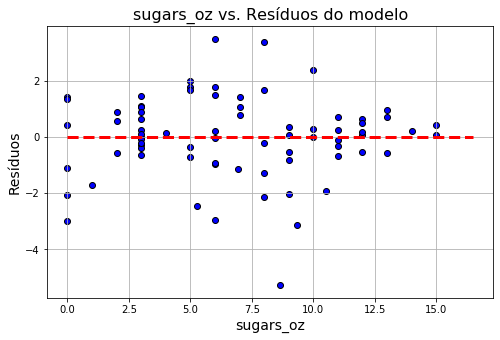

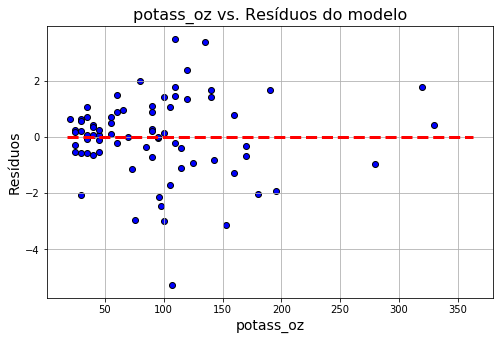

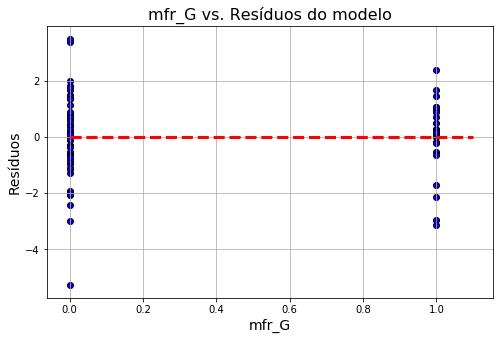

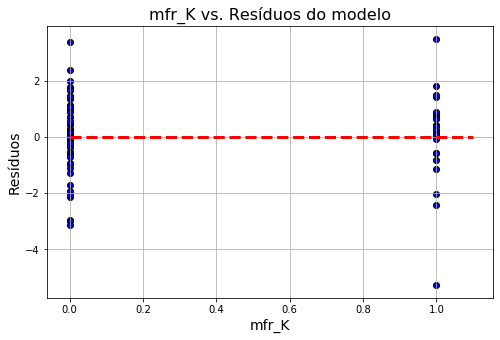

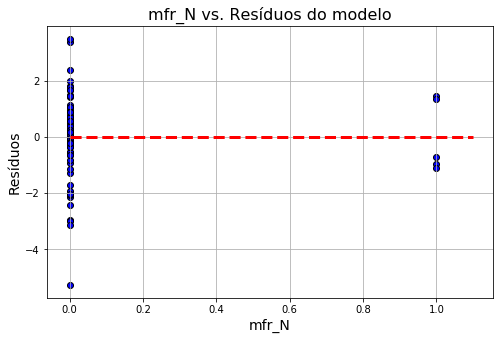

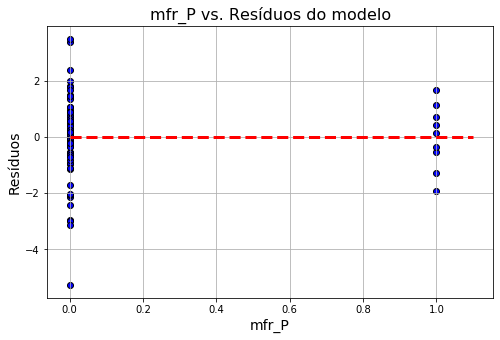

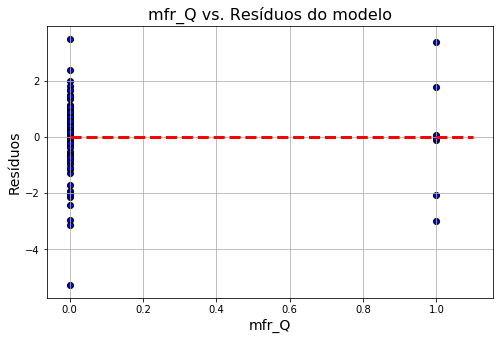

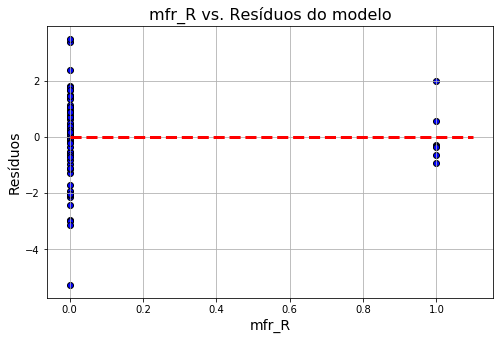

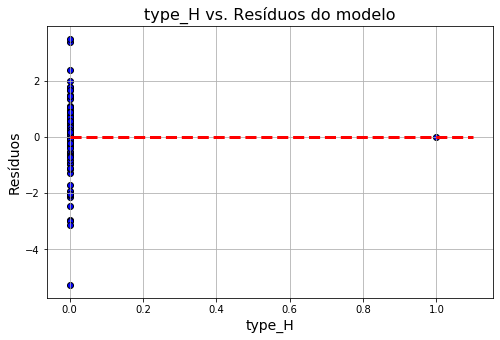

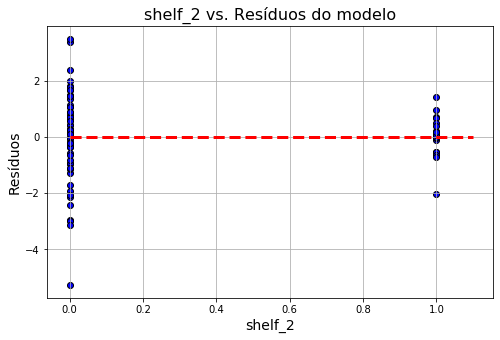

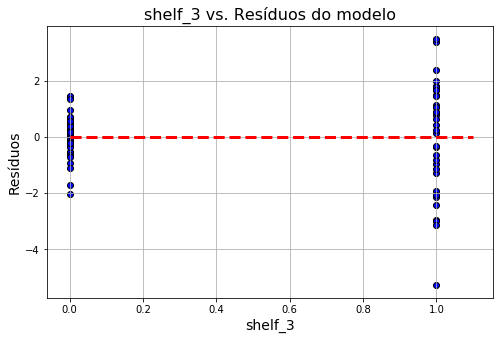

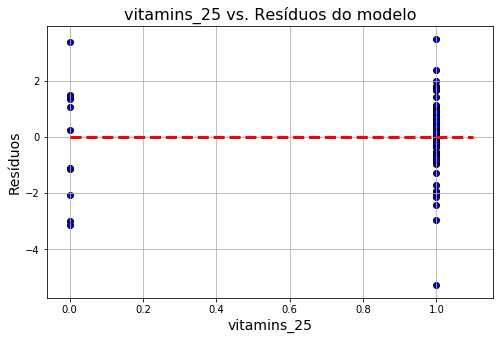

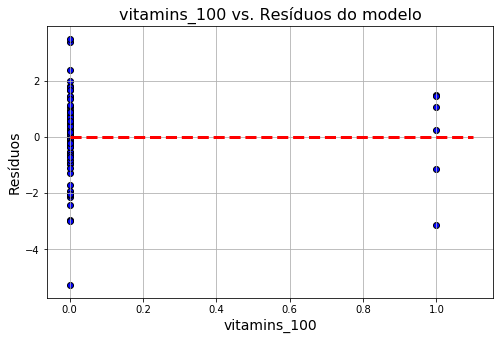

In [0]:
for c in X.columns:
    plt.figure(figsize=(8,5))
    plt.title("{} vs. Resíduos do modelo".format(c), fontsize=16)
    plt.scatter(x=X[c], y=model.resid, color='blue', edgecolor='k')
    plt.grid(True)
    xmin = min(X[c])
    xmax = max(X[c])
    plt.hlines(y=0, xmin=0.9*xmin, xmax=1.1*xmax,
               color='red', linestyle='--', lw=3)
    plt.xlabel(c, fontsize=14)
    plt.ylabel('Resíduos', fontsize=14)
    plt.show()

#### d.2) Plot Ajuste vs. resíduos

Objetivo: Checar homocedasticidade
> A variância dos resíduos deve permanecer constante independentemente dos valores ajustados

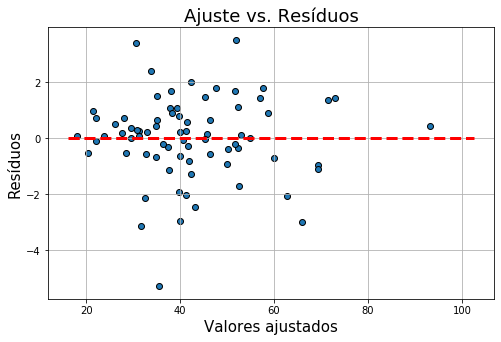

In [0]:
plt.figure(figsize=(8,5))
p = plt.scatter(x=model.fittedvalues, y=model.resid, edgecolor='k')
xmin = min(model.fittedvalues)
xmax = max(model.fittedvalues)
plt.hlines(y=0, xmin=0.9*xmin, xmax=1.1*xmax, 
           color='red', linestyle='--', lw=3)
plt.xlabel("Valores ajustados", fontsize=15)
plt.ylabel("Resíduos", fontsize=15)
plt.title("Ajuste vs. Resíduos", fontsize=18)
plt.grid(True)
plt.show()

#### d.3) Histograma dos resíduos normalizados

Objetivo: Checar normalidade dos resíduos

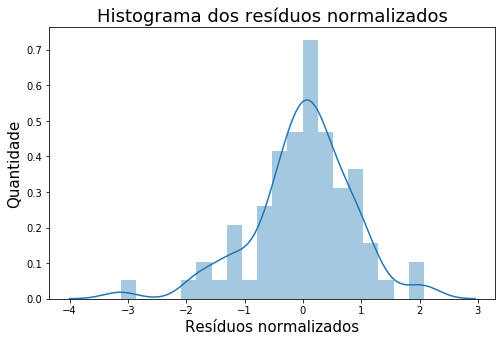

In [0]:
plt.figure(figsize=(8,5))
#plt.hist(model.resid_pearson, bins=20, edgecolor='k')
sns.distplot(model.resid_pearson, bins=20)
plt.ylabel('Quantidade', fontsize=15)
plt.xlabel('Resíduos normalizados', fontsize=15)
plt.title("Histograma dos resíduos normalizados", fontsize=18)
plt.show()

#### d.4) Plot Q-Q dos resíduos

Objetivo: Checar normalidade dos resíduos

<Figure size 576x360 with 0 Axes>

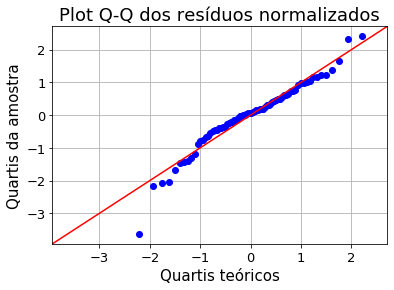

In [0]:
plt.figure(figsize=(8,5))
fig = qqplot(model.resid_pearson, line='45', fit='True')
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.xlabel("Quartis teóricos", fontsize=15)
plt.ylabel("Quartis da amostra", fontsize=15)
plt.title("Plot Q-Q dos resíduos normalizados", fontsize=18)
plt.grid(True)
plt.show()

### d.5) Shapiro-Wilk

Teste adicional para avaliar normalidade

In [0]:
# Valor p deve ser significativo (p < 0.05)
_, p = shapiro(model.resid)
print(p)

0.02512337639927864


## V – Construa um modelo de regressão com todas as variáveis qualitativas e quantitativas significativas.
- Analise a tabela ANOVA
- Interprete os parâmetros do modelo.
- Escreva o modelo ajustado.
- Interprete os parâmetros de qualidade de ajuste R².
- Faça uma análise de resíduos.

### a) Construção do modelo (II)

In [0]:
# Construção do modelo linear usando Statsmodel OLS

X = dfQuanti.drop('rating', axis=1)
X.drop(columns=['potass_oz'], axis=1, inplace=True)
y = dfDummies['rating']

# Adicionar manualmente opção para aplicar regressão com coeficiente linear
x = sm.add_constant(X)

model2 = sm.OLS(y, x).fit()
print(model2.summary())

                            OLS Regression Results                            
Dep. Variable:                 rating   R-squared:                       0.968
Model:                            OLS   Adj. R-squared:                  0.964
Method:                 Least Squares   F-statistic:                     283.8
Date:                Tue, 10 Mar 2020   Prob (F-statistic):           1.08e-46
Time:                        12:50:59   Log-Likelihood:                -172.79
No. Observations:                  74   AIC:                             361.6
Df Residuals:                      66   BIC:                             380.0
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          45.1419      4.558      9.904      

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


### b) Interpretação dos parâmetros do modelo

In [0]:
# Tabela ANOVA
print_anova(model2)

TABELA ANOVA

          Soma de Quadrados  Graus de Liberdade  Erro médio  Valor F
Variação                                                            
Modelo             13914.76                 7.0     1987.82   283.83
Resíduo              462.23                66.0        7.00      NaN


### c) Modelo ajustado

In [0]:
model_str = ' + '.join([str(x) + '*' + y for x, y in zip(round(model2.params[1:], 3), X.columns)])
const = str(round(model2.params[0], 3))
print(y.name + ' = ' + const + ' + ' + model_str)

rating = 45.142 + -0.189*calories_oz + 3.136*protein_oz + -1.984*fat_oz + -0.051*sodium_oz + 2.889*fiber_oz + 1.196*carbo_oz + -0.646*sugars_oz


In [0]:
(((1 + model2.params[1:].values/model2.params[0]) -1) * 100).round(1)

array([-0.4,  6.9, -4.4, -0.1,  6.4,  2.7, -1.4])

### d) Interpretação dos parâmetros do ajuste R²

In [0]:
print(model.rsquared, model.rsquared_adj)

0.9891090193800683 0.9855446984499089


- R² = 0.162 e R²(ajustado) = 0.153
> O valor do coeficiente de ajuste diminuiu, mantendo o baixo desempenho do modelo em se ajustar à variabilidade em torno da média.

> A precisão das previsões do modelo não é boa (apesar de aceitável para alguns tipos de estudo), de forma que o IC de um dado previsto terá alta variabilidade


### e) Análise de resíduos

#### e.1) Plot Resíduos x Variáveis preditivas

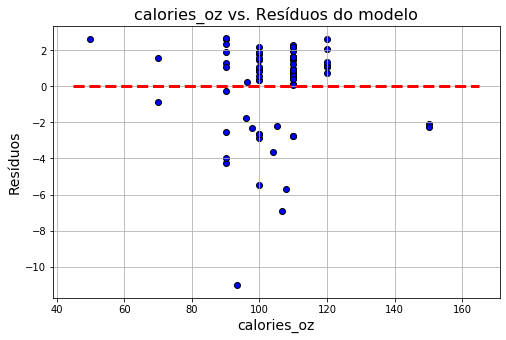

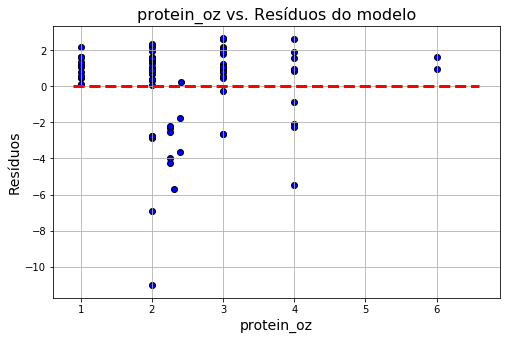

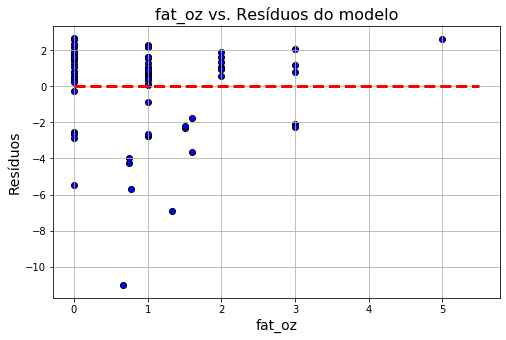

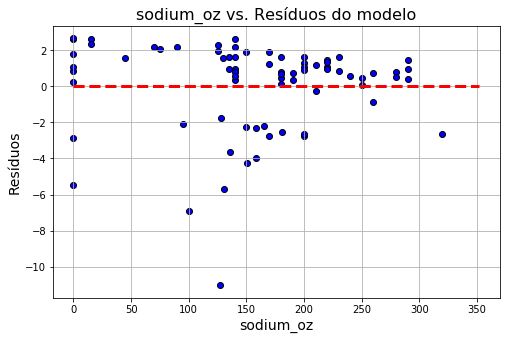

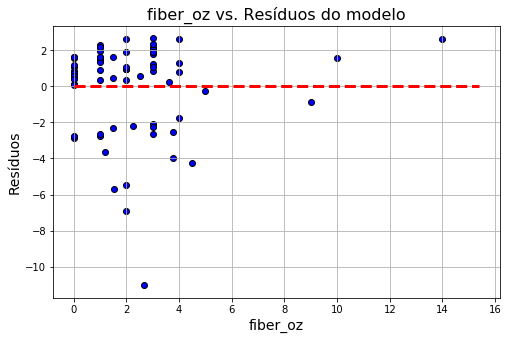

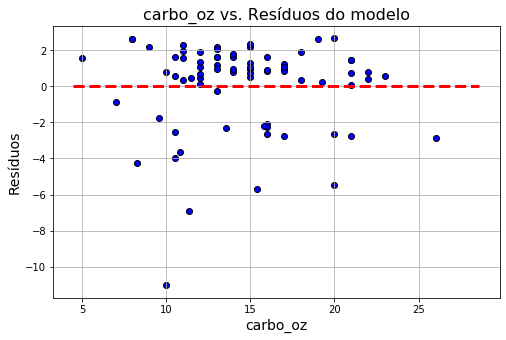

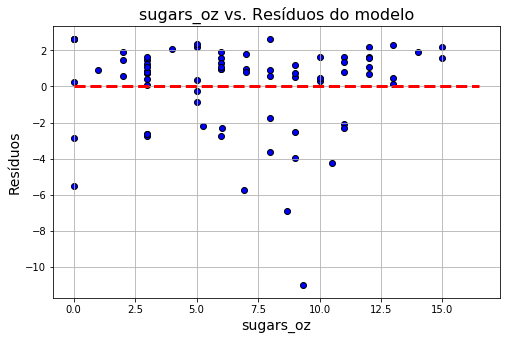

In [0]:
for c in X.columns:
    plt.figure(figsize=(8,5))
    plt.title("{} vs. Resíduos do modelo".format(c), fontsize=16)
    plt.scatter(x=X[c], y=model2.resid, color='blue', edgecolor='k')
    plt.grid(True)
    xmin = min(X[c])
    xmax = max(X[c])
    plt.hlines(y=0, xmin=0.9*xmin, xmax=1.1*xmax,
               color='red', linestyle='--', lw=3)
    plt.xlabel(c, fontsize=14)
    plt.ylabel('Resíduos', fontsize=14)
    plt.show()

#### e.2) Plot Fitted vs. residuals

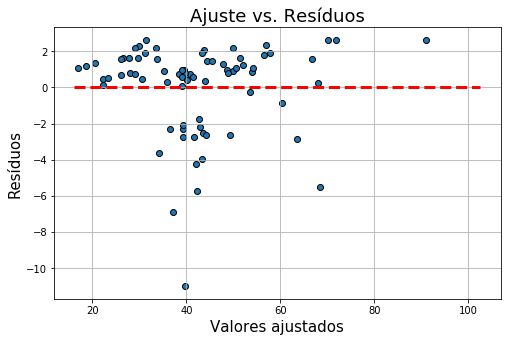

In [0]:
plt.figure(figsize=(8,5))
p = plt.scatter(x=model2.fittedvalues, y=model2.resid, edgecolor='k')
xmin = min(model.fittedvalues)
xmax = max(model.fittedvalues)
plt.hlines(y=0, xmin=0.9*xmin, xmax=1.1*xmax, 
           color='red', linestyle='--', lw=3)
plt.xlabel("Valores ajustados", fontsize=15)
plt.ylabel("Resíduos", fontsize=15)
plt.title("Ajuste vs. Resíduos", fontsize=18)
plt.grid(True)
plt.show()

#### e.3) Histograma dos resíduos normalizados

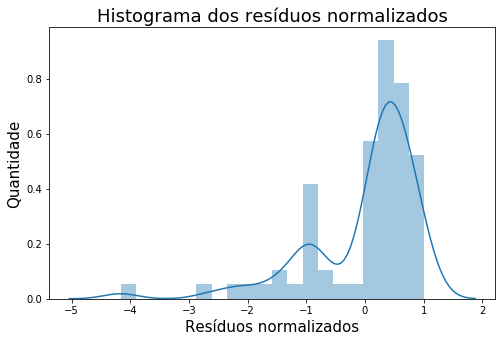

In [0]:
plt.figure(figsize=(8,5))
#plt.hist(model2.resid_pearson, bins=20, edgecolor='k')
sns.distplot(model2.resid_pearson, bins=20)
plt.ylabel('Quantidade', fontsize=15)
plt.xlabel('Resíduos normalizados', fontsize=15)
plt.title("Histograma dos resíduos normalizados", fontsize=18)
plt.show()

#### e.4) Plot Q-Q dos resíduos

<Figure size 576x360 with 0 Axes>

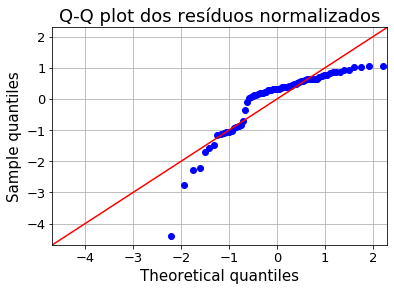

In [0]:
plt.figure(figsize=(8,5))
fig = qqplot(model2.resid_pearson, line='45', fit='True')
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.xlabel("Theoretical quantiles", fontsize=15)
plt.ylabel("Sample quantiles", fontsize=15)
plt.title("Q-Q plot dos resíduos normalizados", fontsize=18)
plt.grid(True)
plt.show()

#### e.5) Shapiro-Wilk

Teste adicional para avaliar normalidade

In [0]:
# Valor p deve ser significativo (p < 0.05)
_, p = shapiro(model2.resid)
print(p)

1.3055066361289391e-08


#### e.6) Fator de Inflação de Variância

Teste para checar multicolinearidade

In [0]:
for i in range(len(X.columns)):
    v = vif(np.matrix(X.values), i)
    print(f'VIF para {X.columns[i]}: {v:.2f}')

VIF para calories_oz: 456.91
VIF para protein_oz: 14.08
VIF para fat_oz: 8.28
VIF para sodium_oz: 4.82
VIF para fiber_oz: 2.71
VIF para carbo_oz: 162.26
VIF para sugars_oz: 42.60


## VI – Ajuste final

Remover variáveis cujo VIF indicou multicolinearidade e avaliar efeito sobre os resíduos do modelo

### a) Construção do modelo (III)

In [37]:
# Construção do modelo linear usando Statsmodel OLS
X = dfQuanti.drop('rating', axis=1)
X.drop(columns=['potass_oz', 'calories_oz', 'protein_oz', 'carbo_oz'], 
       axis=1, inplace=True)
y = dfDummies['rating'].values

# Adicionar manualmente opção para aplicar regressão com coeficiente linear
x = sm.add_constant(X).values

model3 = sm.OLS(y, x).fit()
print(model3.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.941
Model:                            OLS   Adj. R-squared:                  0.938
Method:                 Least Squares   F-statistic:                     276.9
Date:                Tue, 10 Mar 2020   Prob (F-statistic):           1.06e-41
Time:                        17:40:04   Log-Likelihood:                -195.02
No. Observations:                  74   AIC:                             400.0
Df Residuals:                      69   BIC:                             411.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         61.3866      1.331     46.126      0.0

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


### b) Interpretação dos parâmetros do modelo

In [0]:
# Tabela ANOVA
print_anova(model3)

TABELA ANOVA

          Soma de Quadrados  Graus de Liberdade  Erro médio  Valor F
Variação                                                            
Modelo             13533.95                 4.0     3383.49   276.93
Resíduo              843.04                69.0       12.22      NaN


### c) Novo modelo ajustado

In [0]:
model_str = ' + '.join([str(x) + '*' + y for x, y in zip(round(model3.params[1:], 3), X.columns)])
const = str(round(model3.params[0], 3))
print(y.name + ' = ' + const + ' + ' + model_str)

rating = 61.387 + -3.294*fat_oz + -0.052*sodium_oz + 2.74*fiber_oz + -1.998*sugars_oz


In [0]:
(((1 + model2.params[1:].values/model2.params[0]) -1) * 100).round(1)

array([-0.4,  6.9, -4.4, -0.1,  6.4,  2.7, -1.4])

### d) Interpretação dos parâmetros do ajuste R²

In [0]:
print(model3.rsquared, model3.rsquared_adj)

0.9413616318643572 0.9379623061753344


- R² = 0.162 e R²(ajustado) = 0.153
> O valor do coeficiente de ajuste diminuiu, mantendo o baixo desempenho do modelo em se ajustar à variabilidade em torno da média.

> A precisão das previsões do modelo não é boa (apesar de aceitável para alguns tipos de estudo), de forma que o IC de um dado previsto terá alta variabilidade


### e) Análise de resíduos

#### e.1) Plot Resíduos x Variáveis preditivas

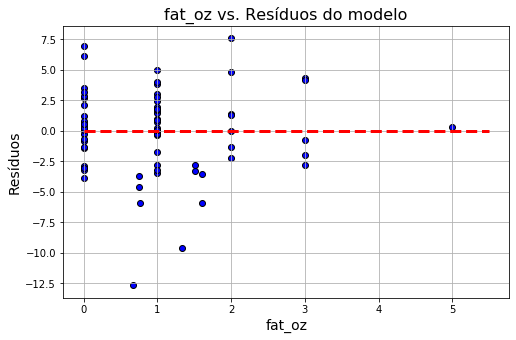

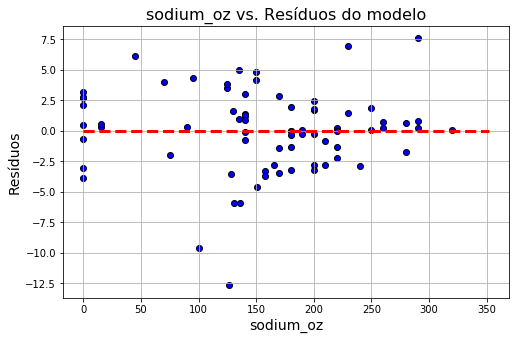

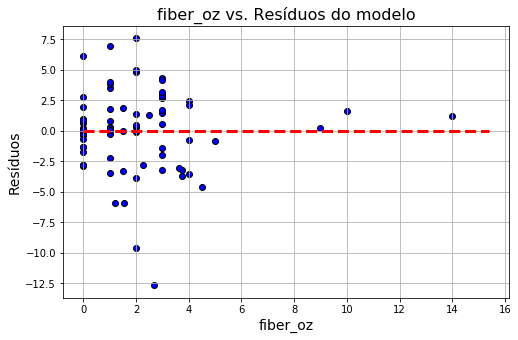

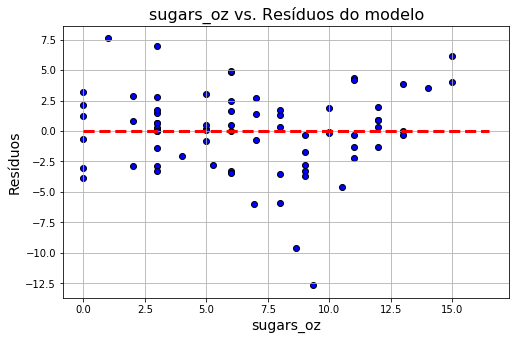

In [0]:
for c in X.columns:
    plt.figure(figsize=(8,5))
    plt.title("{} vs. Resíduos do modelo".format(c), fontsize=16)
    plt.scatter(x=X[c], y=model3.resid, color='blue', edgecolor='k')
    plt.grid(True)
    xmin = min(X[c])
    xmax = max(X[c])
    plt.hlines(y=0, xmin=0.9*xmin, xmax=1.1*xmax,
               color='red', linestyle='--', lw=3)
    plt.xlabel(c, fontsize=14)
    plt.ylabel('Resíduos', fontsize=14)
    plt.show()

#### e.2) Plot Fitted vs. residuals

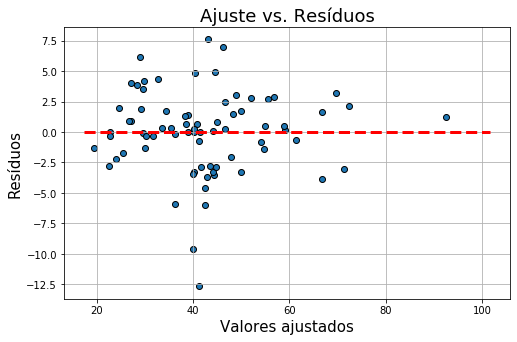

In [0]:
plt.figure(figsize=(8,5))
p = plt.scatter(x=model3.fittedvalues, y=model3.resid, edgecolor='k')
xmin = min(model3.fittedvalues)
xmax = max(model3.fittedvalues)
plt.hlines(y=0, xmin=0.9*xmin, xmax=1.1*xmax, 
           color='red', linestyle='--', lw=3)
plt.xlabel("Valores ajustados", fontsize=15)
plt.ylabel("Resíduos", fontsize=15)
plt.title("Ajuste vs. Resíduos", fontsize=18)
plt.grid(True)
plt.show()

#### e.3) Histograma dos resíduos normalizados

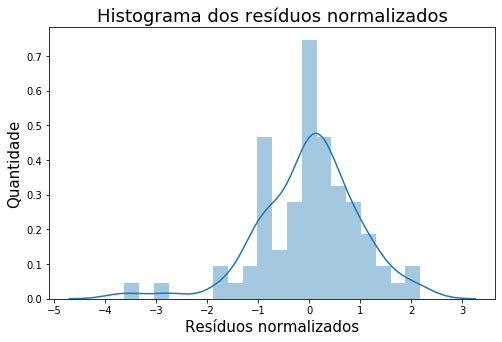

In [0]:
plt.figure(figsize=(8,5))
#plt.hist(model3.resid_pearson, bins=20, edgecolor='k')
sns.distplot(model3.resid_pearson, bins=20)
plt.ylabel('Quantidade', fontsize=15)
plt.xlabel('Resíduos normalizados', fontsize=15)
plt.title("Histograma dos resíduos normalizados", fontsize=18)
plt.show()

#### e.4) Plot Q-Q dos resíduos

<Figure size 576x360 with 0 Axes>

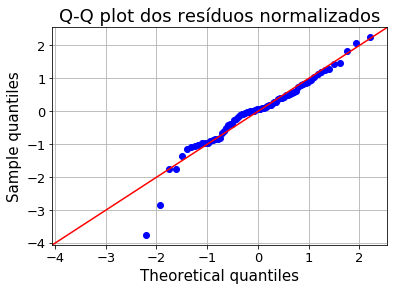

In [0]:
plt.figure(figsize=(8,5))
fig = qqplot(model3.resid_pearson, line='45', fit='True')
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.xlabel("Theoretical quantiles", fontsize=15)
plt.ylabel("Sample quantiles", fontsize=15)
plt.title("Q-Q plot dos resíduos normalizados", fontsize=18)
plt.grid(True)
plt.show()

#### e.5) Shapiro-Wilk

Teste adicional para avaliar normalidade

In [0]:
# Valor p deve ser significativo (p < 0.05)
_, p = shapiro(model3.resid)
print(p)

0.01252931822091341


#### e.6) Fator de Inflação de Variância

Teste para checar multicolinearidade

In [0]:
for i in range(len(X.columns)):
    v = vif(np.matrix(X.values), i)
    print(f'VIF for {X.columns[i]}: {v:.2f}')

VIF for fat_oz: 2.08
VIF for sodium_oz: 2.65
VIF for fiber_oz: 1.47
VIF for sugars_oz: 2.93
